## Введение

Стартапу, продающему продукты питания, нужно разобраться в поведении пользователей мобильного приложения.

Для этого сначала построим воронку продаж и узнаем, как пользователи доходят до покупки, на каких шагах у них могут происходить затруднения.

Далее с помощью А/А/В-теста проверим, повлияло ли на пользователей изменения шрифтов в приложении. В тесте участвуют 2 контрольные группы и одна экспериментальная. Чтобы убедиться в точности проведенного теста сравним между собой контрольные группы - их результаты должны быть одинаковы, в таком случае результаты теста признаются корректными. После чего будем попарно сравнивать контрольные и экспериментальную группы.

Для анализа у нас имеются данные с логами пользователей. 

**Исследование пройдет в несколько этапов:**
* предобработка данных (приведение типов данных, проверка на пропуски и дубликаты)
* исследовательский анализ (проверка данных на полноту и корректность)
* построение и анализ воронки событий
* анализ результатов А/А/В-теста с помощью статистических критериев

## Предобработка данных

In [66]:
pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [67]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy import stats as st
import numpy as np
import math as mth
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [68]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep='\t')
data.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [70]:
# Переименуем колонки.
data.columns = ['event_name', 'user_id', 'timestamp', 'group']

In [71]:
# Проверим на пропуски.
data.isna().sum()

event_name    0
user_id       0
timestamp     0
group         0
dtype: int64

In [72]:
# Проверим на дубликаты.
data.duplicated().sum()

413

In [73]:
# Удалим дубликаты
data = data.drop_duplicates()

In [74]:
# Добавим столбец даты и времени, а также отдельный столбец с датой.
data['event_dt'] = pd.to_datetime(data['timestamp'], unit='s')
data['event_date'] = data['event_dt'].dt.date

In [75]:
# Посмотрим, что получилось.
data.sample(10)

,event_name,user_id,timestamp,group,event_dt,event_date
70638,CartScreenAppear,538346255722523869,1564772718,246,2019-08-02 19:05:18,2019-08-02
97709,PaymentScreenSuccessful,7715390689016577607,1564845831,248,2019-08-03 15:23:51,2019-08-03
83097,MainScreenAppear,8640044487307646984,1564823820,246,2019-08-03 09:17:00,2019-08-03
126764,MainScreenAppear,663948373672770349,1564926662,247,2019-08-04 13:51:02,2019-08-04
66402,CartScreenAppear,1056436874470887468,1564764492,247,2019-08-02 16:48:12,2019-08-02
11531,MainScreenAppear,5438224639833325893,1564650559,248,2019-08-01 09:09:19,2019-08-01
217411,MainScreenAppear,1582082792444414628,1565159627,248,2019-08-07 06:33:47,2019-08-07
32614,PaymentScreenSuccessful,7947548393357958796,1564681967,248,2019-08-01 17:52:47,2019-08-01
158806,CartScreenAppear,2956202147249516728,1565010920,248,2019-08-05 13:15:20,2019-08-05
121723,OffersScreenAppear,7716166848354963661,1564918872,246,2019-08-04 11:41:12,2019-08-04


In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   timestamp   243713 non-null  int64         
 3   group       243713 non-null  int64         
 4   event_dt    243713 non-null  datetime64[ns]
 5   event_date  243713 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 13.0+ MB


## Исследовательский анализ данных

In [77]:
# Посмотрим, сколько всего событий. Одна строка соответствует одному событию.
print(f'Всего событий в логе {len(data)}')

Всего событий в логе 243713


In [78]:
# Посмотрим количество уникальных пользователей
print('Всего событий в логе', len(data['user_id'].unique()))

# Почему-то не сработала f-строка, выдает ошибку 'unmatched ['

Всего событий в логе 7551


In [79]:
# Посчитаем, сколько приходится событий в среднем на одного пользователя.
print('В среднем событий на одного пользователя', round(len(data) / len(data['user_id'].unique())))

В среднем событий на одного пользователя 32


In [80]:
# Определим минимальную и максимальную даты.
print('Минимальная дата:', data['event_date'].min())
print('Максимальная дата:', data['event_date'].max())

Минимальная дата: 2019-07-25
Максимальная дата: 2019-08-07


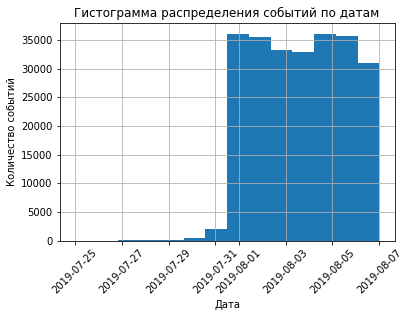

In [81]:
# Посмотрим, как данные распределены по времени.
data['event_date'].hist(bins=14)
plt.xticks(rotation=45)
plt.title('Гистограмма распределения событий по датам')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()

На гистограмме распределения видно, что абсолютное большинство данных приходится на период с 1 августа по 7 августа 2019 года. Оставим для анализа только данные этого периода.

In [82]:
# Убедимся еще раз.
data.groupby('event_date').agg({'event_name':'count'}).sort_values(by='event_date')

,event_name
event_date,
2019-07-25,9
2019-07-26,31
2019-07-27,55
2019-07-28,105
2019-07-29,184
2019-07-30,412
2019-07-31,2030
2019-08-01,36141
2019-08-02,35554


In [83]:
# Оставим для анализа только даты с 1 по 7 августа 2019 года.
data_new = data[data['event_date'] > datetime(2019, 7, 31).date()]

In [84]:
# Посмотрим, какое количество событий мы потеряли. Одна строка в датафрейме соответствует одному событию.
round(1 - len(data_new)/len(data), 3)

0.012

In [85]:
# Посмотрим, какое количество уникальных пользователей мы потеряли.
round(1 - len(data_new['user_id'].unique()) / len(data['user_id'].unique()), 3)


0.002

Мы отбросили всего лишь 1,2% всех данных, это допустимое количество. Что касается уникальных пользователей, то их количество осталось пратически без изменений - отброшено 0,2%.

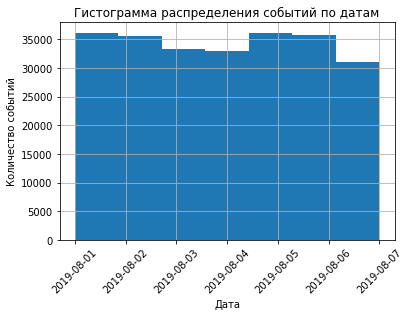

In [86]:
# Посмотрим на новое распределение.
data_new['event_date'].hist(bins=7)
plt.xticks(rotation=45)
plt.title('Гистограмма распределения событий по датам')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()

In [87]:
# Проверим, что в новых данных присутствуют пользователи из всех трех групп.
data_new['group'].unique()

array([246, 247, 248])

Все в порядке, данные распределены равномерно, пользователи из всех групп присутствуют в новых данных. Переходим к анализу.

## Изучение воронки событий

In [88]:
# Сгруппируем данные по событию и посмотрим, как часто случаются события, какое количество пользователей совершают данное
# событие и какова их доля от общего количества пользователей.
funnel = (data_new.groupby('event_name')
          .agg({'event_name':'count', 'user_id':'nunique'})
          .rename(columns={'event_name':'event_count', 'user_id':'user_count'})
          
          .sort_values(by='user_count', ascending=False)
         .reset_index())
funnel['user_percentage'] = round(funnel['user_count'] / len(data_new['user_id'].unique()) * 100, 1)
funnel

,event_name,event_count,user_count,user_percentage
0,MainScreenAppear,117328,7419,98.5
1,OffersScreenAppear,46333,4593,61.0
2,CartScreenAppear,42303,3734,49.6
3,PaymentScreenSuccessful,33918,3539,47.0
4,Tutorial,1005,840,11.1


Предположим последовательность событий:
* обучение (Tutorial)
* просмотр главного экрана (MainScreenAppear)
* просмотр экрана с товаром (OffersScreenAppear)
* просмотр корзины (CartScreenAppear)
* просмотр экрана с успешной оплатой (PaymentScreenSuccessful)

Заметим, что обучение проходят всего 11% пользователей, остальные пропускают этот шаг. 

До успешной оплаты доходят только 17,6% пользователей.

Т.к. шаг Tutorial выбивается из воронки, не будем его учитывать.

In [89]:
funnel = funnel.query('event_name != "Tutorial"')


In [90]:
# Посчитаем конверсию из одного шага в другой и общую конверсию
next_step_conversion =[]
conversion = []
for i in range(len(funnel['user_count'])):
    if i == 0:
        next_step_conversion.append(round(funnel['user_count'][i] / funnel['user_count'][i] * 100, 1))
    else:
        next_step_conversion.append(round(funnel['user_count'][i] / funnel['user_count'][i - 1] * 100, 1))
    conversion.append(round(funnel['user_count'][i] / funnel['user_count'][0] * 100, 1))

In [91]:
# Добавим столбцы с конверсиями в таблицу
funnel['next_step_conversion'] = next_step_conversion
funnel['conversion'] = conversion
funnel

,event_name,event_count,user_count,user_percentage,next_step_conversion,conversion
0,MainScreenAppear,117328,7419,98.5,100.0,100.0
1,OffersScreenAppear,46333,4593,61.0,61.9,61.9
2,CartScreenAppear,42303,3734,49.6,81.3,50.3
3,PaymentScreenSuccessful,33918,3539,47.0,94.8,47.7


Больше всего пользователей теряется на при переходе с главного экрана на экран товара.

От первого события до оплаты доходят 47,7% пользователей.

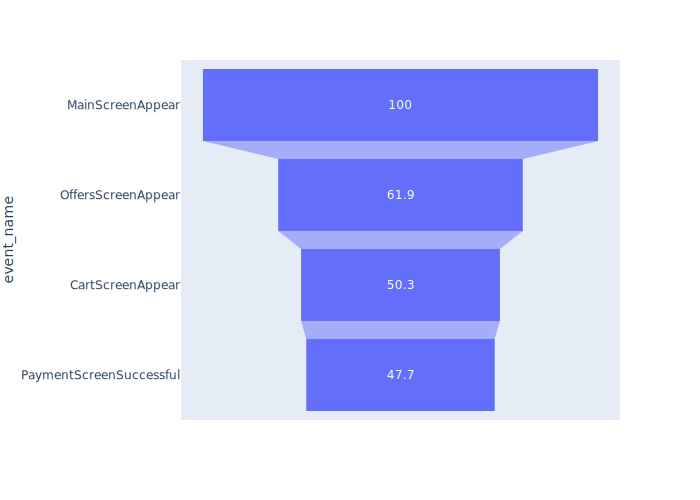

In [92]:
fig = px.funnel(funnel, x='conversion', y='event_name')
fig.show('svg')

## Анализ А/А/В-теста

In [93]:
# Также уберем событие Tutorial из данных.
data_new = data_new.query('event_name != "Tutorial"')

In [94]:
# Посмотрим, как распределены пользователи по группам.
data_new.groupby('group').agg({'user_id':'nunique'})

,user_id
group,
246,2483
247,2512
248,2535


In [95]:
# Посмотрим, количество пользователей по группам и событиям.
groups_users = (data_new 
  .pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique')
  .sort_values(by=246, ascending=False)
  .reset_index()
  )
groups_users

group,event_name,246,247,248
0,MainScreenAppear,2450,2476,2493
1,OffersScreenAppear,1542,1520,1531
2,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181


Перейдем к проверке наличия статистически значимых различий между группами. Для этого сформулируем гипотезы и напишем функцию, которая будет применять z-критерий к 2 группам по определенному событию.

**Н0:** нет различий в конверсии между выборками.

**Н1:** есть различия в конверсии между выборками.

In [96]:
# Функция для определения статистической достоверности различия долей в группах

def get_z(df, event, group1, group2, alpha):
    event = event
    
# Сначала сформируем таблицу с количеством пользователей по группам по выбранному событию
    events_by_groups = (df
                    .query('event_name == @event')
                    .groupby('group')
                    .agg({'user_id':'nunique'})
                    .rename(columns={'user_id':'user_count'}))
    
# Добавим общее количество пользователей в группах   
    events_by_groups = (events_by_groups
                    .merge(df.groupby('group')
                                   .agg({'user_id':'nunique'})
                                   .rename(columns={'user_id':'total_users'}), 
                           on='group'))
    
# Добавим столбец с конверсией    
    events_by_groups['conversion'] = round(events_by_groups['user_count'] / events_by_groups['total_users'], 4)
    
# Определим уровень значимости   
    alpha = alpha
    
# Подготовим данные к расчету z-критерия
    p1 = events_by_groups['conversion'][group1]
    p2 = events_by_groups['conversion'][group2]
    p_combined = ((events_by_groups['user_count'][group1] + events_by_groups['user_count'][group2]) / 
            (events_by_groups['total_users'][group1] + events_by_groups['total_users'][group2]))
    diff = p1 - p2
    
# Посчитаем z_value   
    z_value = diff / mth.sqrt(p_combined * (1 - p_combined)
                          * (1/events_by_groups['total_users'][group1] + 1/events_by_groups['total_users'][group2]))
    
# Зададим нормальное распределение   
    distr = st.norm(0, 1)
    
# Посчитаем p_value    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print(f'Событие {c} в группах {group1} и {group2}')
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу, между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
    print()

In [97]:
# Проверим, есть ли различия между контрольными группами.
for c in data_new['event_name'].unique():
    get_z(data_new, c, 246, 247, 0.05)

Событие MainScreenAppear в группах 246 и 247
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие OffersScreenAppear в группах 246 и 247
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие CartScreenAppear в группах 246 и 247
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие PaymentScreenSuccessful в группах 246 и 247
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Наличие статистически значимых различий между двумя контрольными группами не обнаружено. Из этого можно заключить, что тестирование проведено точно.

Проверим, отличаются ли контрольные группы от экспериментальной.

In [98]:
# Проверим, есть ли различия между первой контрольной группой и экспериментальной.
for c in data_new['event_name'].unique():
    get_z(data_new, c, 246, 248, 0.05)

Событие MainScreenAppear в группах 246 и 248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие OffersScreenAppear в группах 246 и 248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие CartScreenAppear в группах 246 и 248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие PaymentScreenSuccessful в группах 246 и 248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [99]:
# Проверим, есть ли различия между второй контрольной группой и экспериментальной.
for c in data_new['event_name'].unique():
    get_z(data_new, c, 247, 248, 0.05)

Событие MainScreenAppear в группах 247 и 248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие OffersScreenAppear в группах 247 и 248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие CartScreenAppear в группах 247 и 248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие PaymentScreenSuccessful в группах 247 и 248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Статистически значимых различий между контрольными и экспериментальной группой также не обнаружено. Кажется, изменение шрифтов в приложении не оказало никакого влияния на пользователей.

На всякий случай проверим, есть ли различия между объединенной контрольной группой и экспериментальной.

In [100]:
data_new['group'].unique()

array([246, 247, 248])

In [101]:
# Создадим новый датафрейм, где объединим конрольные группы.
data_AB = data_new.copy()
data_AB['group'] = data_AB['group'].replace(247, 246)
data_AB.groupby('group').agg({'user_id':'nunique'})

,user_id
group,
246,4995
248,2535


In [102]:
# Проверим, есть ли различия между объединенными контрольными группами и экспериментальной.
for c in data_new['event_name'].unique():
    get_z(data_AB, c, 246, 248, 0.05)

Событие MainScreenAppear в группах 246 и 248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие OffersScreenAppear в группах 246 и 248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие CartScreenAppear в группах 246 и 248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие PaymentScreenSuccessful в группах 246 и 248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Различий между объединенными группами так же нет.

Для проверки z-критерия был выбран уровень значимости 0,05. При таком уровне значимости каждый двадцатый раз можно получить ложный результат. Мы провели в общей сложности 20 проверок, т.е. есть вероятность, что один из результатов ложный. Попробуем взять уровень значимости 0,01 и посмотреть, что получится.

In [103]:
for c in data_new['event_name'].unique():
    get_z(data_new, c, 246, 247, 0.01)

Событие MainScreenAppear в группах 246 и 247
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие OffersScreenAppear в группах 246 и 247
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие CartScreenAppear в группах 246 и 247
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие PaymentScreenSuccessful в группах 246 и 247
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [104]:
for c in data_new['event_name'].unique():
    get_z(data_new, c, 246, 248, 0.01)

Событие MainScreenAppear в группах 246 и 248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие OffersScreenAppear в группах 246 и 248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие CartScreenAppear в группах 246 и 248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие PaymentScreenSuccessful в группах 246 и 248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [105]:
for c in data_new['event_name'].unique():
    get_z(data_new, c, 247, 248, 0.01)

Событие MainScreenAppear в группах 247 и 248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие OffersScreenAppear в группах 247 и 248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие CartScreenAppear в группах 247 и 248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие PaymentScreenSuccessful в группах 247 и 248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [106]:
for c in data_new['event_name'].unique():
    get_z(data_AB, c, 246, 248, 0.01)

Событие MainScreenAppear в группах 246 и 248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие OffersScreenAppear в группах 246 и 248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие CartScreenAppear в группах 246 и 248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие PaymentScreenSuccessful в группах 246 и 248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



При уровне значимости 0.01 также не выявлено никаких различий.

## Общий вывод


**Воронка событий.**

Получилась следующая воронка событий:
* просмотр главного экрана (MainScreenAppear)
* просмотр экрана с товаром (OffersScreenAppear)
* просмотр корзины (CartScreenAppear)
* просмотр экрана с успешной оплатой (PaymentScreenSuccessful)

Шаг Tutorial был отброшен, т.к. его проходят всего лишь 11,1% пользователей. Далее обнаружилось, что больше всего пользователей теряется при переходе с главного экрана на страницу с товаров - 38,1% не доходит до этого шага. Это большое количество пользователей, возможно существует какая-то техническая проблема с приложением на их устройствах. До этапа корзины доходит 50,3% пользователей и совершают оплату 47,7% пользователей. Разница в количестве пользователей между этими шагами незначительная, поэтому не стоит говорить от проблемах в приложении, возможно, пользователям по какой-то причине становится неактуальна покупка.

**А/А/В-тест.**

Тесты проведенные с уровнями значимости 0,05 и 0,01 не выявили никаких значимых статистических различий между контрольными и экспериментальной группами ни на одном шаге. Можно заключить, что изменение шрифтов никак не сказалось на пользователях.
